# Neural Style Transfer

The following notebook illustrates generation of a new image with content of one picture and style of another.

Idea was presented in [arxiv:1508.06576](https://arxiv.org/pdf/1508.06576.pdf)

The content of the noteboook is based on the pytorch article: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

---

First, import required packages.

In [480]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torchvision.models as models

import copy

Get GPU if available

In [481]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading images

Load images, show them and resize to $500 \times 500$:

In [482]:
def apply_transform(img):
    # Convert to (C, H, W)
    img = T.ToTensor()(img)
        
    # Make resize
    img = T.Resize((500, 500))(img)
    
    # Add batch dimension
    img = img.unsqueeze(0).to(device)

    return img

In [483]:
def load_image(path_img):
    img = Image.open(path_img)
    if img.size[0] != img.size[1]:
        raise Exception("Image size has to be square")
    
    return apply_transform(img)

In [484]:
def show_tensor_img(tensor_img, title):
    # Clone the tensor to not do changes on it
    img = tensor_img.cpu().clone()
    # Remove the fake batch dimension
    img = img.squeeze(0)
    # Convert to PIL image
    img = T.ToPILImage()(img)
    # Show image
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(title)
    plt.show()

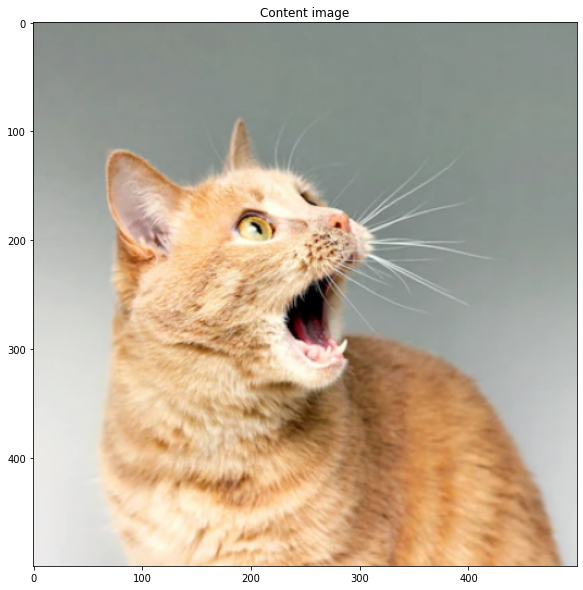

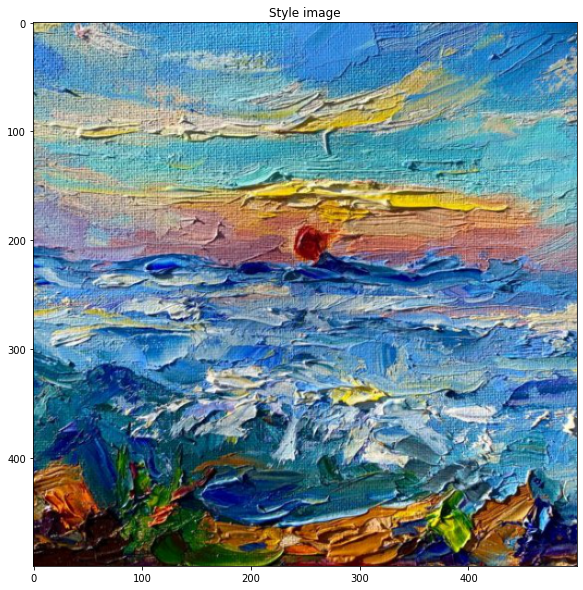

In [485]:
# Load images and apply transforms
content_img = load_image("content.jpg")
style_img = load_image("style.jpg")

# Show loaded images
show_tensor_img(content_img, "Content image")
show_tensor_img(style_img, "Style image")

## Loss

Content loss:

In [486]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

Gram matrix calculation for style loss:

In [487]:
def gram_matrix(input):
    # Batch size, number of feature maps, dimensions of a feature map
    a, b, c, d = input.size()

    # Resise input tensor to matrix (unite spatial coordinates over which multiplication is performed)
    features = input.view(a * b, c * d)

    # Get gram matrix by matrix multiplication
    G = torch.mm(features, features.t())

    # Normalize by dividing by the number of element
    return G / (a * b * c * d)

Style loss:

In [488]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Model

Define normalization layer

In [489]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()

    def forward(self, img):
        return T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))(img)

Define function that creates model and losses

In [490]:
def get_model_and_losses(style_img, content_img):
    # Get pretrained model - VGG19
    cnn = models.vgg19(pretrained=True).features.to(device).eval()
    
    # Layers to compute style and content losses
    content_layers = ['conv_4']
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
    
    # List of losses
    content_losses = []
    style_losses = []

    # Initialize model
    model = nn.Sequential(Normalization())

    i = 0  # Increment every time we see a conv
    for layer in cnn.children():
        # Get layer name
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)  # The in-place version doesn't play very nicely with the ContentLoss and StyleLoss
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        # Add layer to model
        model.add_module(name, layer)

        # Add layer with content loss
        if name in content_layers:
            target = model(content_img).detach()  # Get target feature map for loss
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        # Add layer with style loss
        if name in style_layers:
            target_feature = model(style_img).detach()  # Get target feature map for loss
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Trim off the layers after the last content loss and style loss layers
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]

    return model, style_losses, content_losses

## Optimizer

In [491]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

## Input image

Define input image. It can be noise or content image:

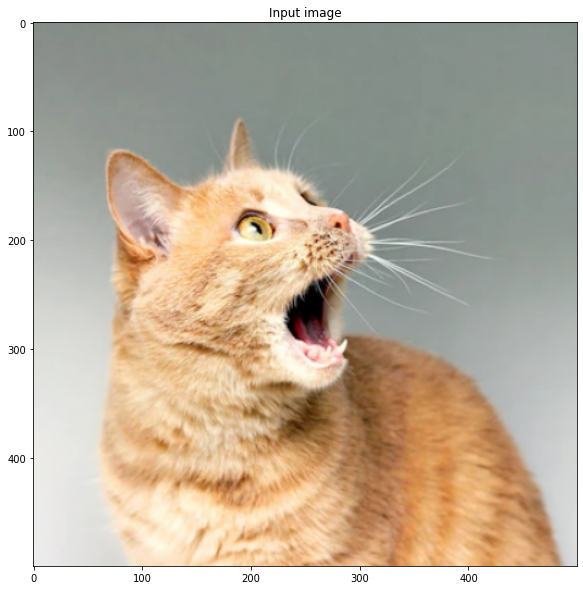

In [492]:
input_img = content_img.clone()
show_tensor_img(input_img, "Input image")

## Training

Define function for training.

During the training we update input image values, but model parameters stay fixed.

In [493]:
def run_style_transfer(content_img, style_img, input_img, num_steps=300, style_weight=1000000, content_weight=5):
    # Get model and losses
    model, style_losses, content_losses = get_model_and_losses(style_img, content_img)

    # Fix model params and set grad for input values
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    # Get optimizer
    optimizer = get_input_optimizer(input_img)

    # Training
    print('Start of training:\n')
    epoch = 0
    while epoch < num_steps:
        
        # Nessesary construction for LBFGS optimizer
        def closure():
            nonlocal epoch
            
            # Clip to correct range
            with torch.no_grad():
                input_img.clamp_(0, 1)
            
            # Apply model
            optimizer.zero_grad()
            model(input_img)
            
            # Find losses
            style_score = 0
            content_score = 0
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            # Multiply losses by weights
            style_score *= style_weight
            content_score *= content_weight

            # Backpropagation
            loss = style_score + content_score
            loss.backward()

            # Update iteration and show info
            epoch += 1
            if epoch % 50 == 0:
                print(f"Epoch: {epoch}")
                print('Style Loss: {:4f}, Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return loss

        optimizer.step(closure)
    
    # Clip to correct range
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Run style transfer with obtained model and images

In [494]:
output = run_style_transfer(
    content_img,
    style_img,
    input_img
)

Start of training:

Epoch: 50
Style Loss: 93.948448, Content Loss: 145.986603

Epoch: 100
Style Loss: 22.384047, Content Loss: 123.097565

Epoch: 150
Style Loss: 11.360797, Content Loss: 109.973061

Epoch: 200
Style Loss: 8.054793, Content Loss: 102.068443

Epoch: 250
Style Loss: 7.522089, Content Loss: 97.498611

Epoch: 300
Style Loss: 5.521873, Content Loss: 95.664299



Show result

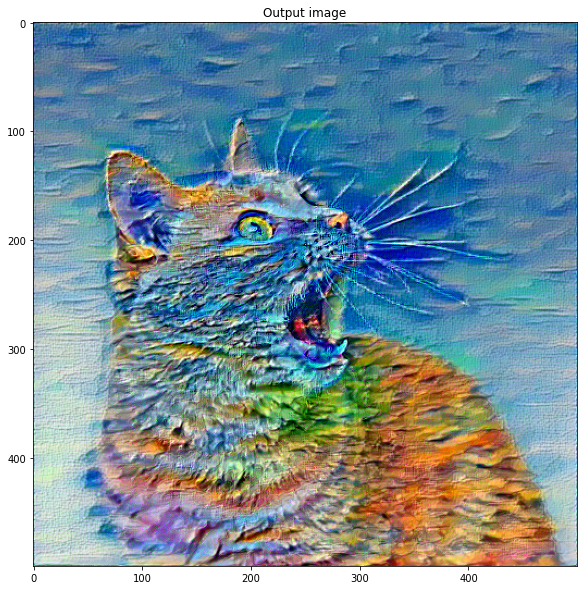

In [495]:
show_tensor_img(output, "Output image")